In [ ]:
# import sys
# import os

# ### Installs all the packages in the install library (my_custom_libs) ##

# # --- 1. SETUP PATHS FIRST (you are going to need to change to whatever your path to the instal library is in) ---
# username = os.environ.get('USER')
# scratch_base = f"/scratch/midway3/{username}/fea_project"
# custom_lib_path = os.path.join(scratch_base, "my_custom_libs")
# hf_cache_path = os.path.join(scratch_base, "hf_cache")

# py_version = f"python{sys.version_info.major}.{sys.version_info.minor}"
# site_packages = os.path.join(custom_lib_path, "lib", py_version, "site-packages")
# sys.path.insert(0, site_packages)

# # FORCE custom path to the FRONT of the list
# if site_packages not in sys.path:
#     sys.path.insert(0, site_packages)

# print(f"Python is looking here first: {sys.path[0]}")

# # --- Ensure current directory is in sys.path for Windows ---
# current_dir = os.getcwd()
# if current_dir not in sys.path:
#     sys.path.insert(0, current_dir)
#     print(f"Added current directory to sys.path: {current_dir}")

# # --- 2. ENV VARIABLES ---
# os.environ['HF_HOME'] = hf_cache_path
# os.environ['TRANSFORMERS_CACHE'] = hf_cache_path
# os.environ['PYTHONUSERBASE'] = custom_lib_path

# # --- 3. NOW IMPORT LIBRARIES ---
# # Only import AFTER sys.path is updated
# import datasets 
# import sentence_transformers
# from sentence_transformers import SentenceTransformer

# # --- 4. VERIFY PATHS ---
# print(f"Datasets is loaded from: {os.path.dirname(datasets.__file__)}")

# if "software" in os.path.dirname(datasets.__file__):
#     print("FAILURE: Still loading system datasets.")
# else:
#     print("SUCCESS: All libraries isolated in scratch.")


Python is looking here first: /scratch/midway3/None/fea_project\my_custom_libs\lib\python3.13\site-packages
Added current directory to sys.path: c:\Users\aesteva\Documents\GitHub\fea_project


KeyboardInterrupt: 

In [17]:
import sys
import os
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.insert(0, current_dir)
    print(f"Added current directory to sys.path: {current_dir}")

import pandas as pd
import numpy as np
import importlib
import free_entailments_algorithm_utils as fea
import plotly.express as px

importlib.reload(fea)

# Load premise and conclusion dataframes
df_p = pd.read_excel("ClauseLevel_df_p.xlsx")
df_sc = pd.read_excel("ClauseLevel_df_sc.xlsx")

print(f"Premises:    {len(df_p):,} rows")
print(f"Conclusions: {len(df_sc):,} rows")

Premises:    49,155 rows
Conclusions: 15,289 rows


In [ ]:
# Count total valid BB and BS candidate pairs (before any threshold)
# Valid pairs are within-group only (premise-premise OR conclusion-conclusion, never cross)

for label, df_src in [("Premises", df_p), ("Conclusions", df_sc)]:
    book_ids = df_src.loc[df_src['sentence_id'].str.startswith('B'), 'sentence_id']
    speech_ids = df_src.loc[df_src['sentence_id'].str.startswith('S'), 'sentence_id']
    n_b, n_s = len(book_ids), len(speech_ids)
    bb = n_b * (n_b - 1) // 2
    bs = n_b * n_s
    print(f"{label}: {n_b:,} book IDs, {n_s:,} speech IDs → {bb:,} BB pairs, {bs:,} BS pairs")

# Total across both groups
total_bb = sum(
    len(df_src.loc[df_src['sentence_id'].str.startswith('B')]) *
    (len(df_src.loc[df_src['sentence_id'].str.startswith('B')]) - 1) // 2
    for df_src in [df_p, df_sc]
)
total_bs = sum(
    len(df_src.loc[df_src['sentence_id'].str.startswith('B')]) *
    len(df_src.loc[df_src['sentence_id'].str.startswith('S')])
    for df_src in [df_p, df_sc]
)
print(f"\nTotal candidate BB pairs: {total_bb:,}")
print(f"Total candidate BS pairs: {total_bs:,}")
print(f"Grand total:              {total_bb + total_bs:,}")

Premises: 9,564 book IDs, 39,591 speech IDs → 45,730,266 BB pairs, 378,648,324 BS pairs
Conclusions: 2,511 book IDs, 12,778 speech IDs → 3,151,305 BB pairs, 32,085,558 BS pairs

Total candidate BB pairs: 48,881,571
Total candidate BS pairs: 410,733,882
Grand total:              459,615,453


In [ ]:
# Number of pairs per type
N = 100000

# Generate N Book-Book pairs and N Book-Speech pairs
df_pairs_bb, df_pairs_bs = fea.generate_valid_pairs_by_type(
    df_p, df_sc,
    n=N,
    id_col='sentence_id',
    text_col='sentence',
    random_seed=68
)

print(f"\ndf_pairs_bb shape: {df_pairs_bb.shape}")
print(f"df_pairs_bs shape: {df_pairs_bs.shape}")
df_pairs_bb.head()


=== Generating 100,000 Book-Book pairs ===
  Generated 100,000 Book-Book pairs

=== Generating 100,000 Book-Speech pairs ===
  Generated 100,000 Book-Speech pairs

=== SUMMARY ===
Book-Book pairs:   100,000
Book-Speech pairs: 100,000

df_pairs_bb shape: (100000, 4)
df_pairs_bs shape: (100000, 4)


id1         id2                                              text1  \
0   B0578007p   B0649003p  The king's authority is reduced when his abili...   
1   B0800009p   B1085003p  This perspective emphasizes that power origina...   
2  B0852004sc  B1192002sc     A sovereign governor maintains the common good   
3   B0165006p   B0575004p  The presence of assemblies and councils serves...   
4  B0297002sc  B0738004sc         Liberty contradicts the essence of freedom   

                                               text2  
0            This shift in focus can lead to tyranny  
1  Such a shift in allegiance can lead to rebelli...  
2                   Civil authority deserves respect  
3  The imposition of taxes is contingent upon the...  
4  Consulting counselors and optimates improves t...

In [ ]:
import pickle
with open("embedding_cache_finetuned.pkl", 'rb') as f:
    embedding_cache_finetuned = pickle.load(f)
print(f"Loaded embedding cache: {len(embedding_cache_finetuned)} embeddings")

Loaded embedding cache: 63909 embeddings


In [ ]:
# Compute cosine similarity using the fine-tuned bi-encoder model
df_pairs_bb = fea.generate_new_bert_results(
    df_pairs_bb,
    text_col1='text1',
    text_col2='text2',
    model_path='./fine_tuned_bi_model',
    new_col='cosine_sim',
    embedding_cache=embedding_cache_finetuned,
    id_col1='id1',
    id_col2='id2'
)

df_pairs_bs = fea.generate_new_bert_results(
    df_pairs_bs,
    text_col1='text1',
    text_col2='text2',
    model_path='./fine_tuned_bi_model',
    new_col='cosine_sim',
    embedding_cache=embedding_cache_finetuned,
    id_col1='id1',
    id_col2='id2'
)

print("Book-Book cosine_sim stats:")
print(df_pairs_bb['cosine_sim'].describe())
print("\nBook-Speech cosine_sim stats:")
print(df_pairs_bs['cosine_sim'].describe())

Using pre-computed embeddings from cache...
Using pre-computed embeddings from cache...
Book-Book cosine_sim stats:
count    100000.000000
mean          0.000000
std           0.076233
min           0.229492
25%           0.522461
50%           0.573242
75%           0.625488
max           0.970215
Name: cosine_sim, dtype: float64

Book-Speech cosine_sim stats:
count    100000.000000
mean          0.000000
std           0.071411
min           0.260010
25%           0.485840
50%           0.533203
75%           0.582031
max           0.929199
Name: cosine_sim, dtype: float64


/scratch/midway3/aesteva/fea_project/my_custom_libs/lib/python3.11/site-packages/pandas/core/nanops.py:1512: RuntimeWarning:

overflow encountered in cast

/scratch/midway3/aesteva/fea_project/my_custom_libs/lib/python3.11/site-packages/pandas/core/nanops.py:1512: RuntimeWarning:

overflow encountered in cast



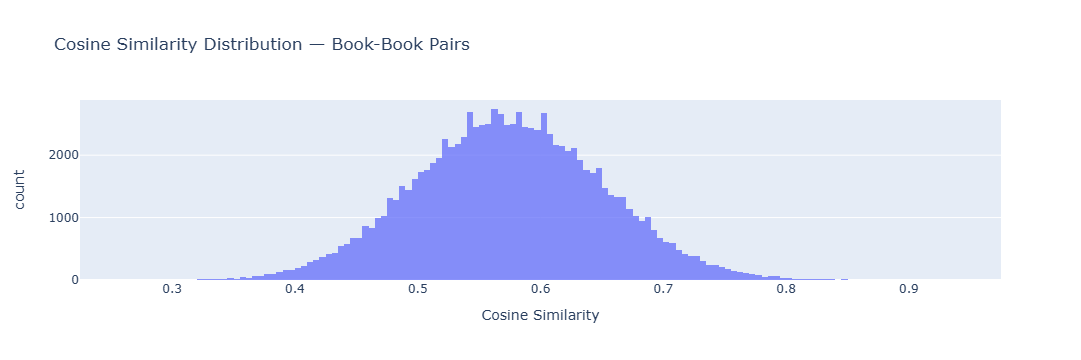

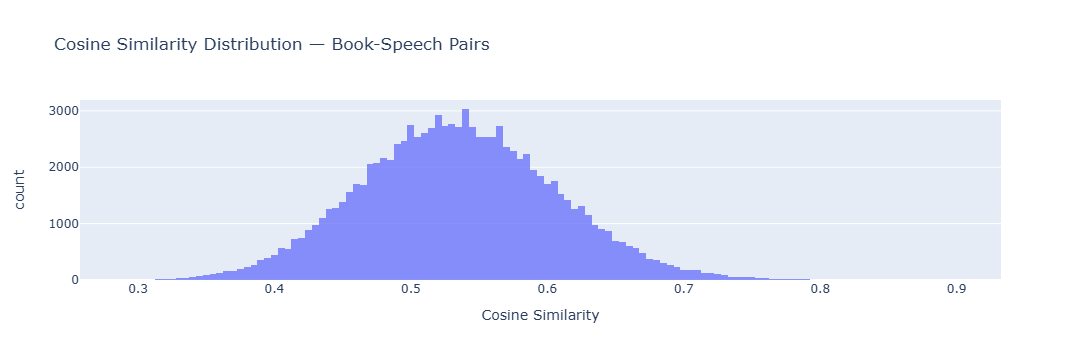

In [ ]:
# Plot cosine similarity distributions
fig_bb = px.histogram(
    df_pairs_bb, x='cosine_sim', nbins=200,
    title='Cosine Similarity Distribution — Book-Book Pairs',
    labels={'cosine_sim': 'Cosine Similarity'},
    opacity=0.75,
)
fig_bb.show()

fig_bs = px.histogram(
    df_pairs_bs, x='cosine_sim', nbins=200,
    title='Cosine Similarity Distribution — Book-Speech Pairs',
    labels={'cosine_sim': 'Cosine Similarity'},
    opacity=0.75,
)
fig_bs.show()

In [ ]:
# Find the 99th-percentile threshold (top 1% = cos_sim above this value)
threshold_bb = np.percentile(df_pairs_bb['cosine_sim'].dropna(), 99)
threshold_bs = np.percentile(df_pairs_bs['cosine_sim'].dropna(), 99)

print(f"Book-Book   — top 1% threshold: {threshold_bb:.6f}")
print(f"Book-Speech — top 1% threshold: {threshold_bs:.6f}")

Book-Book   — top 1% threshold: 0.753418
Book-Speech — top 1% threshold: 0.708496


In [ ]:
importlib.reload(fea)

# Run 20 trials with different random seeds to check threshold stability
df_thresholds = fea.estimate_thresholds(
    df_p, df_sc,
    n_trials=10,
    n_pairs=100000,
    percentile=99.0,
    model_path='./fine_tuned_bi_model',
    embedding_cache=embedding_cache_finetuned,
)

print("\n=== Threshold Stability Summary ===")
print(df_thresholds[['threshold_bb', 'threshold_bs']].describe())

print(f"\nthreshold_bb  →  mean={df_thresholds['threshold_bb'].mean():.6f}  std={df_thresholds['threshold_bb'].std():.6f}")
print(f"threshold_bs  →  mean={df_thresholds['threshold_bs'].mean():.6f}  std={df_thresholds['threshold_bs'].std():.6f}")

# Use the mean thresholds for the final scan
threshold_bb = df_thresholds['threshold_bb'].mean()
threshold_bs = df_thresholds['threshold_bs'].mean()
print(f"\nUsing mean thresholds: BB={threshold_bb:.6f}, BS={threshold_bs:.6f}")

  Trial 1/10  (seed=0) … 
=== Generating 100,000 Book-Book pairs ===
  Generated 100,000 Book-Book pairs

=== Generating 100,000 Book-Speech pairs ===
  Generated 100,000 Book-Speech pairs

=== SUMMARY ===
Book-Book pairs:   100,000
Book-Speech pairs: 100,000
Using pre-computed embeddings from cache...
Using pre-computed embeddings from cache...
BB=0.755859  BS=0.707520
  Trial 2/10  (seed=1) … 
=== Generating 100,000 Book-Book pairs ===
  Generated 100,000 Book-Book pairs

=== Generating 100,000 Book-Speech pairs ===
  Generated 100,000 Book-Speech pairs

=== SUMMARY ===
Book-Book pairs:   100,000
Book-Speech pairs: 100,000
Using pre-computed embeddings from cache...
Using pre-computed embeddings from cache...
BB=0.754395  BS=0.706055
  Trial 3/10  (seed=2) … 
=== Generating 100,000 Book-Book pairs ===
  Generated 100,000 Book-Book pairs

=== Generating 100,000 Book-Speech pairs ===
  Generated 100,000 Book-Speech pairs

=== SUMMARY ===
Book-Book pairs:   100,000
Book-Speech pairs: 10

In [ ]:
# Generate threshold-filtered pairs, keeping:
#   - 100k randomly sampled B-B pairs (from all ~350k above threshold)
#   - 100k randomly sampled B-S pairs (from top 1M above threshold by cos sim)
# BS results are trimmed per-group to cap memory during the scan.
importlib.reload(fea)

df_all_filtered = fea.generate_valid_pairs(
    df_p, df_sc,
    id_col='sentence_id',
    text_col='sentence',
    embedding_cache=embedding_cache_finetuned,
    threshold_bb=threshold_bb,
    threshold_bs=threshold_bs,
    batch_size=64,
    sample_n_bb=100_000,
    sample_n_bs=100_000,
    top_k_bs=1_000_000,
)

# Split by pair type
df_pairs_bb_final = df_all_filtered[df_all_filtered['pair_type'] == 'BB'].reset_index(drop=True)
df_pairs_bs_final = df_all_filtered[df_all_filtered['pair_type'] == 'BS'].reset_index(drop=True)

print(f"\nBook-Book pairs:   {len(df_pairs_bb_final):,}")
print(f"Book-Speech pairs: {len(df_pairs_bs_final):,}")

print("\n--- Book-Book sample ---")
display(df_pairs_bb_final.head())

print("\n--- Book-Speech sample ---")
display(df_pairs_bs_final.head())


=== Generating filtered premise-premise pairs ===
    [Premises] Scanning 45,730,266 B-B candidates in batches of 64...
    [Premises] Found 297,517 B-B pairs above threshold 0.7550
    [Premises] Scanning 378,648,324 B-S candidates  (book batch=64, speech chunk=2048)...
    [Premises] Found 1,917,302 B-S pairs above threshold 0.7065
    [Premises] Trimmed B-S to top 1,000,000 by cosine_sim

=== Generating filtered conclusion-conclusion pairs ===
    [Conclusions] Scanning 3,151,305 B-B candidates in batches of 64...
    [Conclusions] Found 43,091 B-B pairs above threshold 0.7550
    [Conclusions] Scanning 32,085,558 B-S candidates  (book batch=64, speech chunk=2048)...
    [Conclusions] Found 487,191 B-S pairs above threshold 0.7065
Randomly sampled 100,000 B-B pairs from 340,608
Randomly sampled 100,000 B-S pairs from top 1,000,000

=== SUMMARY (threshold-filtered) ===
Book-Book pairs:    100,000
Book-Speech pairs:  100,000
Total pairs:        200,000

Book-Book pairs:   100,000
Boo

id1        id2  cosine_sim pair_type  \
0  B0258006p  B0969002p    0.760782        BB   
1  B0509009p  B0707006p    0.761272        BB   
2  B0358007p  B0769001p    0.776661        BB   
3  B0565002p  B0742003p    0.774899        BB   
4  B0004006p  B0208001p    0.791295        BB   

                                               text1  \
0  The power to confer sovereignty inherently res...   
1  This dedicated authority safeguards against th...   
2  The people's authority transcends that of the ...   
3  The essence of kingship is that a king cannot ...   
4  The notion that any individual, regardless of ...   

                                               text2  
0  The historical context demonstrates that the a...  
1  The role of the ephors is crucial, as it preve...  
2  The people can reclaim their power from a king...  
3  A king is subject only to God and not to any e...  
4  A king who does not rule according to law cann...


--- Book-Speech sample ---


id1           id2  cosine_sim pair_type  \
0  B0448009p  S0017838003p    0.756132        BS   
1  B1024002p  S0003653005p    0.743731        BS   
2  B0861003p  S0018513005p    0.759859        BS   
3  B0239001p  S0022713006p    0.757845        BS   
4  B0661008p  S0022639005p    0.729780        BS   

                                               text1  \
0  Aristocracies and popular states often result ...   
1  Subjects may feel oppressed by the sovereign's...   
2  The happiness and safety of the subjects are d...   
3  The concept of annual Parliaments is essential...   
4  This approach preserves the sanctity of religi...   

                                               text2  
0  This period of political tension is marked by ...  
1  The monarchy's influence threatens to overshad...  
2  The urgency of the situation demands that the ...  
3  It is essential to ensure that the rights of P...  
4  This proactive stance is crucial for restoring...

In [ ]:
merged_df = pd.concat([df_pairs_bs_final, df_pairs_bb_final], ignore_index=True)
merged_df = merged_df.drop(columns='pair_type')
merged_df = merged_df.rename(columns={'cosine_sim': 'score'})
merged_df.shape

(200000, 5)

In [ ]:
df_round_0 = merged_df

df_round_0.head()

id1           id2     score  \
0  B0448009p  S0017838003p  0.756132   
1  B1024002p  S0003653005p  0.743731   
2  B0861003p  S0018513005p  0.759859   
3  B0239001p  S0022713006p  0.757845   
4  B0661008p  S0022639005p  0.729780   

                                               text1  \
0  Aristocracies and popular states often result ...   
1  Subjects may feel oppressed by the sovereign's...   
2  The happiness and safety of the subjects are d...   
3  The concept of annual Parliaments is essential...   
4  This approach preserves the sanctity of religi...   

                                               text2  
0  This period of political tension is marked by ...  
1  The monarchy's influence threatens to overshad...  
2  The urgency of the situation demands that the ...  
3  It is essential to ensure that the rights of P...  
4  This proactive stance is crucial for restoring...

In [ ]:
df_round_0.to_excel('df_round_0.xlsx', index=False)

NameError: name 'df_round_0' is not defined

In [18]:
df_round_0 = pd.read_excel("df_round_0.xlsx")


In [38]:
df_round_0_test = df_round_0.sample(n=5)
df_round_0 = df_round_0_test
df_round_0.shape

(5, 5)

In [ ]:
import os, sys

verification = input("Do you want to proceed with LLM calls on this sample? (y/n) ")
if verification.lower() != 'y':
    raise KeyError("LLM calls aborted by user")

# --- Set DeepSeek API key (always overwrite to ensure correct key is used) ---
os.environ["DEEPSEEK_API_KEY"] = "sk-a56d84bca7444177938c4a15f888f78b"

# Format df_round_0 to match evaluator's expected schema
df_llm_input = df_round_0.rename(columns={'score': 'entailment_probability'})
df_llm_input = fea.format_df_to_llm(df_llm_input)
print(f"Formatted columns: {list(df_llm_input.columns)}")

# Save formatted CSV for the evaluator
temp_dir = "fea_iterations/temp_data"
os.makedirs(temp_dir, exist_ok=True)
input_csv = os.path.join(temp_dir, "df_round_0.csv")
df_llm_input.to_csv(input_csv, index=False)
print(f"Saved df_llm_input ({len(df_llm_input)} rows) to {input_csv}")

# Add llm_calls to sys.path so we can import the evaluator directly
llm_calls_dir = os.path.join(os.getcwd(), "llm_calls")
if llm_calls_dir not in sys.path:
    sys.path.insert(0, llm_calls_dir)

import importlib
import deepseek_evaluator as etb
importlib.reload(etb)
from llm_calls.prompts import *

# Configure arguments as if called from CLI
output_base = "labeled_pairs/Results_DS_BtoS_iteration_0"  # evaluator appends .csv
sys.argv = [
    "deepseek_evaluator.py",
    "--model", "deepseek-reasoner",
    "--file", input_csv,
    "--external", "ArgLevel_ClauseIds_df.xlsx",
    "--prompt", "test_prompt_tot_json2",
    "--output", output_base,
]

print(f"Running evaluator with {len(df_llm_input)} pairs...")
etb.main()
print("✓ Evaluator complete")


Formatted columns: ['sentence_id_2', 'sentence_id_1', 'sentence_text_2', 'argument_id_2', 'sentence_text_1', 'argument_id_1', 'score']
Saved df_llm_input (5 rows) to fea_iterations/temp_data\df_round_0.csv
Running evaluator with 5 pairs...
Loading data from fea_iterations/temp_data\df_round_0.csv...
Loading data from ArgLevel_ClauseIds_df.xlsx...
Loaded 5 sentence pairs
Using model: deepseek-reasoner
Using prompt type: test_prompt_tot_json2
Running batch evaluation...


100%|██████████| 5/5 [00:00<00:00, 97.21it/s]


[DEBUG] content length: 1336, reasoning_content length: 7377
[DEBUG] content preview: {
  "sentence_id_1": "B0250002p",
  "sentence_id_2": "S0024022007p",
  "answers": "NO, NO, NO",
  "reasoning": "1. Statement 1 asserts that kings act in a public capacity, but this does not logically entail that they respect parliamentary rights, as even absolute monarchs may claim to act for the pu
[DEBUG] reasoning preview: First, I need to assess whether Statement 1 entails Statement 2. Statement 1 is: "Kings act in a public capacity on behalf of the societies they govern." Statement 2 is: "A constitutional monarchy respects the rights of Parliament and fosters a sense of political engagement among the populace."

Ent
Saved results to labeled_pairs/Results_DS_BtoS_iteration_0.csv
✓ Evaluator complete


In [42]:
df_result = pd.read_csv("labeled_pairs\Results_DS_BtoS_iteration_0.csv")
df_result.head()

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\aesteva\AppData\Local\Temp\ipykernel_2612\1671877592.py:1: SyntaxWarning: invalid escape sequence '\R'
  df_result = pd.read_csv("labeled_pairs\Results_DS_BtoS_iteration_0.csv")


sentence_id_1  sentence_id_2     answers_12  \
0     B0250002p   S0024022007p     NO, NO, NO   
1     B0857002p   S0019926002p     NO, NO, NO   
2    B0529002sc  S0080505003sc    YES, NO, NO   
3     B0378005p   S0019529005p  YES, YES, YES   
4     B0173006p   S0023614007p    NO, YES, NO   

                                       reasonings_12  \
0  1. Statement 1 asserts that kings act in a pub...   
1  1. Logical analysis: Statement 1 asserts that ...   
2  1. YES: In Locke's political theory, legitimat...   
3  1. Logical entailment: Protecting the people i...   
4  1. NO: From a strict logical perspective, Stat...   

                                          comment_12  llm_confidence_12  \
0  I am confident that Statement 1 does not entai...                  3   
1  I am completely sure because Maxwell's text ve...                  4   
2  I am fairly confident that Statement 1 does no...                  3   
3  The connection between the king's duty to prot...                  4   
4  The entailment is not logically necessary, and...                  3   

  llm_conclusion_12  
0                NO  
1                NO  
2                NO  
3               YES  
4                NO